In [1]:
import random
import numpy as np
import LDPC_Gauss
import matplotlib.pyplot as plt
import importlib
importlib.reload(LDPC_Gauss)

In [2]:
# dbs = [0.05*i for i in range(101)]
dbs = [0.25*i for i in range(21)]
n = 1000
s = 1000
undecodedErros = []
codedErros = []
ldpc = LDPC_Gauss.LDPC(n, 5, 10)
for db in dbs:
    print(db)
    undErr = 0
    decErr = 0
    for k in range(s):
        canalGauss = LDPC_Gauss.CanalGauss(10**(db/10))
        v = [0]*n
        r = canalGauss.canal(v)
        c = [0 if r[i] >= 0 else 1 for i in range(len(r))]
        for i in range(len(c)):
            if c[i] == 1:
                undErr += 1
        L = canalGauss.LLR(r)
        o = canalGauss.beliefPropagation(L, ldpc.VNodes, ldpc.CNodes)
        for i in range(len(o)):
            if o[i] == 1:
                decErr += 1

    undecodedErros.append(undErr/(n*s))
    codedErros.append(decErr/(n*s))

0.0


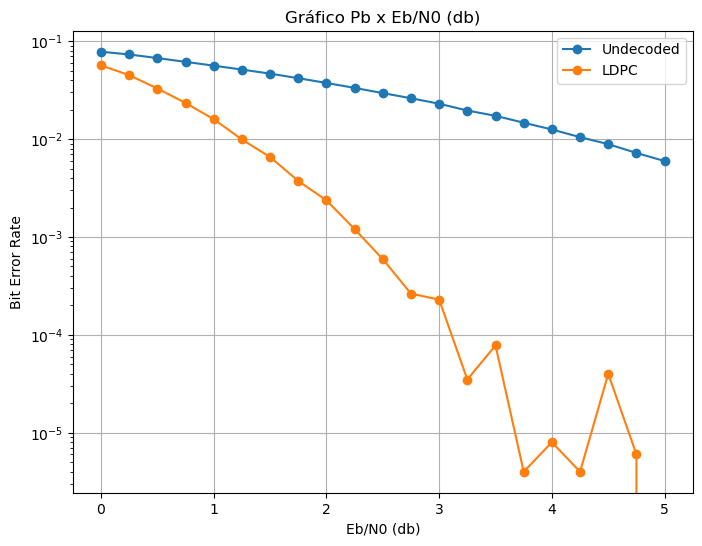

In [ ]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(8, 6))

# Plotando os dados
plt.plot(dbs, undecodedErros, marker='o', label='Undecoded')
plt.plot(dbs, codedErros, marker='o', label='LDPC')
plt.yscale("log") 

# Configurando o título e os rótulos dos eixos
plt.title('Gráfico Pb x Eb/N0 (db)')
plt.xlabel('Eb/N0 (db)')
plt.ylabel('Bit Error Rate')

# Adicionando a legenda
plt.legend()

# plt.ylim([0.005, 0.1])

# Exibindo o gráfico
plt.grid(True)
plt.show()